### Этот ноутбук создан для обучения, уже размеченных полных текстов

In [2]:
import json
import pandas as pd
import numpy as np

import tqdm as notebook_tqdm
from datasets import Dataset

import ast

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from transformers import XLMRobertaForSequenceClassification, Trainer, TrainingArguments, XLMRobertaTokenizer, DataCollatorWithPadding, TrainerCallback

import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax

import optuna

import seaborn as sns
import matplotlib.pyplot as plt


/root/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CUDA not available")

True
NVIDIA GeForce RTX 4090


In [48]:
marked_df=df_final_lemmatized[df_final_lemmatized['label']!=-1]
marked_df.head(3)

,Исполнитель,Трек,Собран,Жанр,Доп. информация,Фит,Совместный релиз,Альбом,Год выхода,Текст трека,Языки в тексте,Части текста,Обработанные части,Очищенные леммы,label,trigger
original_index,,,,,,,,,,,,,,,,
https://music.yandex.ru/album/14163163/track/78713811,ИЧИ,16,1.0,русский рэп,Нет,Нет,Несовместный релиз,ЦПХ,2021.0,"Как жалко, что нам не 16\nКак жалко (как жалко...",[ru],"[Как жалко, что нам не 16\nКак жалко (как жалк...","[[как, жалко, ,, что, мы, не, 16, как, жалко, ...","[[жалко, 16, жалко, жалко, эх, знать, занимать...",1,барыга
https://music.yandex.ru/album/17626885/track/50384685,Kuznetsky Squad,Леденец,1.0,русская поп-музыка,Нет,Нет,Несовместный релиз,Let Me Love U,2019.0,"Мне такие песни легче писать\nНаверное, потому...",[ru],"[Мне такие песни легче писать\nНаверное, потом...","[[я, такой, песня, легкий, писать, наверное, ,...","[[песня, легкий, писать, наверное, романтик], ...",0,nan
https://music.yandex.ru/album/21205963/track/100838843,ESTETIKA,Круэлла,1.0,рэп и хип-хоп,Нет,Нет,Несовместный релиз,Сингл,2022.0,"Мне пох вообще на всех, на все, нули на счет —...",[ru],"[Мне пох вообще на всех, на все, нули на счет ...","[[я, похотеть, вообще, на, все, ,, на, все, ,,...","[[похотеть, вообще, нуль, счет, хороший, забит...",1,Забил сумку крупным налом и ныряю в ...шок


In [49]:
marked_df['label'].value_counts()

label
0    2870
1    1401
Name: count, dtype: int64

#### Классы несбалансированны, надо сбалансировать, попробуем весами

In [ ]:
# Веса обратно пропорциональны частоте
class_counts = torch.tensor([2870, 1401], dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # нормализация

print(class_weights)


tensor([0.3280, 0.6720])


In [55]:
print("Всего примеров:", len(marked_df))

# Разделение данных на обучающую, валидационную и тестовую выборки
train_df, temp_df = train_test_split(marked_df, test_size=0.3, stratify=marked_df["label"], random_state=5)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=5)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(f"Разбиение для модели: обучающая={len(train_df)}, валид.={len(val_df)}, тестовая={len(test_df)}")

Всего примеров: 4271
Разбиение для модели: обучающая=2989, валид.=641, тестовая=641


#### Токенизация текстов и создание Dataset

In [ ]:
# Инициализация токенизатора XLM-RoBERTa
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Функция токенизации для применения к батчам данных
def tokenize_batch(batch):
    return tokenizer(batch["Текст трека"], padding="max_length", truncation=True, max_length=128)

# Преобразование в Dataset
train_dataset = Dataset.from_pandas(train_df[["Текст трека", "label"]], preserve_index=False)
val_dataset = Dataset.from_pandas(val_df[["Текст трека", "label"]], preserve_index=False)
test_dataset = Dataset.from_pandas(test_df[["Текст трека", "label"]], preserve_index=False)

# Токенизация
train_dataset = train_dataset.map(tokenize_batch, batched=False)
val_dataset = val_dataset.map(tokenize_batch, batched=False)
test_dataset = test_dataset.map(tokenize_batch, batched=False)

# Удаляем тексты, оставлим только данные для модели
train_dataset = train_dataset.remove_columns("Текст трека")
val_dataset = val_dataset.remove_columns("Текст трека")
test_dataset = test_dataset.remove_columns("Текст трека")


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Проверка результата токенизации на примере первой записи обучающей выборки
print(train_dataset[0])


Map: 100%|██████████| 641/641 [00:01<00:00, 514.79 examples/s]

{'label': 0, 'input_ids': [0, 44054, 312, 27830, 216721, 155030, 59, 134385, 12868, 10948, 195551, 1730, 7329, 29, 551, 589, 107178, 2732, 6860, 551, 44054, 312, 27830, 216721, 155030, 59, 134385, 12868, 10948, 195551, 1730, 7329, 29, 551, 589, 107178, 2732, 6860, 551, 83559, 216721, 155030, 59, 218, 589, 6, 15176, 2151, 61, 11054, 419, 38, 134385, 12332, 1082, 85169, 59, 10948, 1509, 150719, 24747, 4222, 2732, 3925, 61, 96313, 7836, 38, 44054, 312, 28434, 77, 29776, 29, 49270, 31, 672, 22145, 1794, 29, 33303, 819, 59, 2395, 89335, 27600, 77, 29, 111437, 252, 49, 779, 2871, 40965, 5235, 28434, 819, 241805, 227, 3151, 2871, 44054, 312, 35, 24898, 49, 14744, 67998, 779, 77, 819, 77, 2032, 2395, 417, 28434, 54087, 12149, 11848, 157843, 8979, 17224, 38, 1509, 29, 92086, 103, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
# модель XLM-RoBERTa для классификации
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

# Функция для вычисления метрик качества
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Преобразуем logits модели в предсказанные классы
    predictions = np.argmax(logits, axis=-1)
    # Вычисляем метрики
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
# взвешенный тренер
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.tensor([0.328, 0.672]).to(device)

In [ ]:
# Задаём параметры обучения
training_args = TrainingArguments(
    output_dir="xlmr_classificator",   
    num_train_epochs=6,                         
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch", 
    save_strategy="epoch",                     
    save_total_limit=1,
    logging_strategy="epoch",                  
    learning_rate=2e-5,                        
    load_best_model_at_end=True,               
    metric_for_best_model="eval_f1",           
    greater_is_better=True,                    
    seed=5
)

trainer = WeightedTrainer(
    class_weights=weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Обучение модели
trainer.train()

/tmp/ipykernel_1409/1784220465.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.701500,0.691203,0.672387,0.586463,0.501221,0.406586
2,0.681700,0.670324,0.677067,0.688866,0.713468,0.670573
3,0.645100,0.595671,0.698908,0.687275,0.711397,0.685149
4,0.567300,0.588402,0.723869,0.684305,0.675019,0.678848
5,0.497900,0.633271,0.733229,0.695247,0.674655,0.681657
6,0.443900,0.706066,0.720749,0.687208,0.695895,0.690631


TrainOutput(global_step=2244, training_loss=0.5895634071499694, metrics={'train_runtime': 179.8872, 'train_samples_per_second': 99.696, 'train_steps_per_second': 12.474, 'total_flos': 1179658416706560.0, 'train_loss': 0.5895634071499694, 'epoch': 6.0})

#### Тест модели

Метрики на тестовой выборке: {'eval_loss': 0.7272384166717529, 'eval_accuracy': 0.7223088923556942, 'eval_precision': 0.6842265943012211, 'eval_recall': 0.679576766229472, 'eval_f1': 0.6816817319495592, 'eval_runtime': 1.0041, 'eval_samples_per_second': 638.382, 'eval_steps_per_second': 80.669, 'epoch': 6.0}

Классификационный отчёт:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       430
           1       0.58      0.55      0.57       211

    accuracy                           0.72       641
   macro avg       0.68      0.68      0.68       641
weighted avg       0.72      0.72      0.72       641



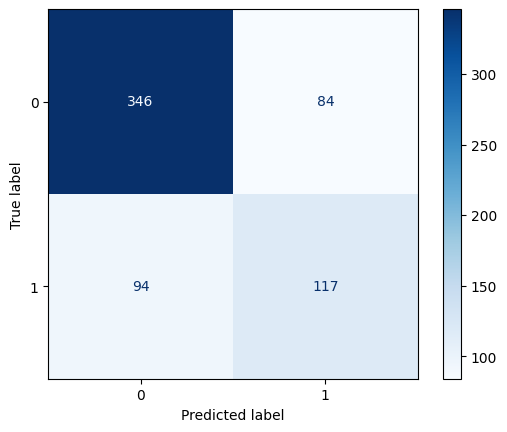

In [78]:
test_metrics = trainer.evaluate(test_dataset)
print("Метрики на тестовой выборке:", test_metrics)

# Подробный анализ
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("\nКлассификационный отчёт:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

### А теперь подберем гиперпараметры оптюной

In [99]:
# Кастомный Trainer с функцией потерь
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [100]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "eval_f1": f1}

In [101]:
# Модель и токенизатор
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [102]:
def model_init():
    return XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

# Токенизация
def tokenize_batch(batch):
    return tokenizer(batch["Текст трека"], padding="max_length", truncation=True, max_length=512)

# Подготовка датасетов (train_df, val_df, test_df — уже загружены как pandas.DataFrame)
train_dataset = Dataset.from_pandas(train_df[["Текст трека", "label"]], preserve_index=False)
val_dataset = Dataset.from_pandas(val_df[["Текст трека", "label"]], preserve_index=False)
test_dataset = Dataset.from_pandas(test_df[["Текст трека", "label"]], preserve_index=False)

train_dataset = train_dataset.map(tokenize_batch, batched=False)
val_dataset = val_dataset.map(tokenize_batch, batched=False)
test_dataset = test_dataset.map(tokenize_batch, batched=False)

train_dataset = train_dataset.remove_columns("Текст трека")
val_dataset = val_dataset.remove_columns("Текст трека")
test_dataset = test_dataset.remove_columns("Текст трека")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 641/641 [00:01<00:00, 436.88 examples/s]


In [ ]:
# Пространство гиперпараметров
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 6),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.3),
    }

In [104]:
# Временный Trainer для поиска
trainer_for_search = WeightedTrainer(
    class_weights=weights,
    model_init=model_init,
    args=TrainingArguments(
        output_dir="xlmr_hp_search_temp",
        eval_strategy="epoch",
        save_strategy="no",
        logging_strategy="no",
        report_to="none",
        disable_tqdm=True,
        per_device_train_batch_size=8,  
        num_train_epochs=2,             
        seed=5
    ),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_1409/1355604549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [105]:
# Запуск поиска гиперпараметров
best_trial = trainer_for_search.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=30,
    compute_objective=lambda metrics: metrics["eval_f1"]
)

[I 2025-05-20 11:44:52,374] A new study created in memory with name: no-name-6da4e764-da9b-4d4e-8011-58f1360cd38b
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.6541427593830604, 'eval_loss': 0.6327242255210876, 'eval_accuracy': 0.7441497659906396, 'eval_precision': 0.7348785990545768, 'eval_recall': 0.6449287371561153, 'eval_runtime': 2.5343, 'eval_samples_per_second': 252.926, 'eval_steps_per_second': 31.961, 'epoch': 1.0}
{'eval_f1': 0.7097826765752826, 'eval_loss': 0.541680634021759, 'eval_accuracy': 0.7285491419656787, 'eval_precision': 0.7058341002760994, 'eval_recall': 0.727333996243509, 'eval_runtime': 2.551, 'eval_samples_per_second': 251.277, 'eval_steps_per_second': 31.753, 'epoch': 2.0}
{'train_runtime': 77.0352, 'train_samples_per_second': 77.601, 'train_steps_per_second': 4.855, 'train_loss': 0.6267329333300259, 'epoch': 2.0}


[I 2025-05-20 11:46:11,076] Trial 0 finished with value: 0.7097826765752826 and parameters: {'learning_rate': 6.1265951084087395e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.15560253331745622, 'warmup_ratio': 0.23528779278377157}. Best is trial 0 with value: 0.7097826765752826.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.6927300857394634, 'eval_loss': 0.6349825263023376, 'eval_accuracy': 0.7394695787831513, 'eval_precision': 0.7028705260629353, 'eval_recall': 0.6866202629543696, 'eval_runtime': 2.5671, 'eval_samples_per_second': 249.695, 'eval_steps_per_second': 31.553, 'epoch': 1.0}
{'eval_f1': 0.6727050727050727, 'eval_loss': 0.55446457862854, 'eval_accuracy': 0.6770670826833073, 'eval_precision': 0.6992839389276837, 'eval_recall': 0.7232350016572754, 'eval_runtime': 2.5719, 'eval_samples_per_second': 249.233, 'eval_steps_per_second': 31.494, 'epoch': 2.0}
{'train_runtime': 77.392, 'train_samples_per_second': 77.243, 'train_steps_per_second': 4.833, 'train_loss': 0.6322934155795663, 'epoch': 2.0}


[I 2025-05-20 11:47:30,272] Trial 1 finished with value: 0.6727050727050727 and parameters: {'learning_rate': 2.253702033144951e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'weight_decay': 0.13437121480732248, 'warmup_ratio': 0.16105302665363194}. Best is trial 0 with value: 0.7097826765752826.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.5993117334315945, 'eval_loss': 0.6656467914581299, 'eval_accuracy': 0.7035881435257411, 'eval_precision': 0.660274316000573, 'eval_recall': 0.5988951497072147, 'eval_runtime': 2.5475, 'eval_samples_per_second': 251.62, 'eval_steps_per_second': 31.796, 'epoch': 1.0}
{'eval_f1': 0.6698730728335991, 'eval_loss': 0.6151717901229858, 'eval_accuracy': 0.7098283931357254, 'eval_precision': 0.6703011192041215, 'eval_recall': 0.6694619379074136, 'eval_runtime': 2.5472, 'eval_samples_per_second': 251.649, 'eval_steps_per_second': 31.8, 'epoch': 2.0}
{'eval_f1': 0.670951902689432, 'eval_loss': 0.6033234000205994, 'eval_accuracy': 0.7129485179407177, 'eval_precision': 0.6728388100769074, 'eval_recall': 0.6693404043752071, 'eval_runtime': 2.5478, 'eval_samples_per_second': 251.592, 'eval_steps_per_second': 31.792, 'epoch': 3.0}
{'train_runtime': 115.8636, 'train_samples_per_second': 77.393, 'train_steps_per_second': 4.842, 'train_loss': 0.6548585398736909, 'epoch': 3.0}


[I 2025-05-20 11:49:27,891] Trial 2 finished with value: 0.670951902689432 and parameters: {'learning_rate': 1.5793040172765316e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'weight_decay': 0.24672938573958503, 'warmup_ratio': 0.22438310525313246}. Best is trial 0 with value: 0.7097826765752826.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.7030498442120199, 'eval_loss': 0.5808504223823547, 'eval_accuracy': 0.7269890795631825, 'eval_precision': 0.6984058683714449, 'eval_recall': 0.7139653077008066, 'eval_runtime': 2.5467, 'eval_samples_per_second': 251.696, 'eval_steps_per_second': 31.806, 'epoch': 1.0}
{'eval_f1': 0.6807195863516264, 'eval_loss': 0.5597857236862183, 'eval_accuracy': 0.6926677067082684, 'eval_precision': 0.6857360198170435, 'eval_recall': 0.7104187382609657, 'eval_runtime': 2.5522, 'eval_samples_per_second': 251.154, 'eval_steps_per_second': 31.737, 'epoch': 2.0}
{'train_runtime': 90.878, 'train_samples_per_second': 65.78, 'train_steps_per_second': 8.231, 'train_loss': 0.6066608530952331, 'epoch': 2.0}


[I 2025-05-20 11:51:00,467] Trial 3 finished with value: 0.6807195863516264 and parameters: {'learning_rate': 6.935352658653782e-06, 'per_device_train_batch_size': 8, 'num_train_epochs': 2, 'weight_decay': 0.12064358966993946, 'warmup_ratio': 0.030818909801582094}. Best is trial 0 with value: 0.7097826765752826.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.6420397766238856, 'eval_loss': 0.5776715278625488, 'eval_accuracy': 0.6443057722308893, 'eval_precision': 0.6826023391812865, 'eval_recall': 0.7000939122748868, 'eval_runtime': 2.5414, 'eval_samples_per_second': 252.219, 'eval_steps_per_second': 31.872, 'epoch': 1.0}
{'eval_f1': 0.62402496099844, 'eval_loss': 0.7117549777030945, 'eval_accuracy': 0.62402496099844, 'eval_precision': 0.7082090376753949, 'eval_recall': 0.7082090376753949, 'eval_runtime': 2.5462, 'eval_samples_per_second': 251.744, 'eval_steps_per_second': 31.812, 'epoch': 2.0}
{'eval_f1': 0.713494158216327, 'eval_loss': 0.5580799579620361, 'eval_accuracy': 0.7207488299531981, 'eval_precision': 0.7254793079261164, 'eval_recall': 0.755717600265164, 'eval_runtime': 2.547, 'eval_samples_per_second': 251.666, 'eval_steps_per_second': 31.802, 'epoch': 3.0}
{'eval_f1': 0.7529669517474396, 'eval_loss': 0.5652471780776978, 'eval_accuracy': 0.7722308892355694, 'eval_precision': 0.7466540172195699, 'eval_recall': 0.7671

[I 2025-05-20 11:54:15,347] Trial 4 finished with value: 0.7547793732313175 and parameters: {'learning_rate': 2.2309853703773973e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0779373242742173, 'warmup_ratio': 0.26001579543774245}. Best is trial 4 with value: 0.7547793732313175.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.709616308600453, 'eval_loss': 0.6129738688468933, 'eval_accuracy': 0.7425897035881436, 'eval_precision': 0.7084288677803253, 'eval_recall': 0.710915920892719, 'eval_runtime': 2.546, 'eval_samples_per_second': 251.764, 'eval_steps_per_second': 31.814, 'epoch': 1.0}
{'eval_f1': 0.7329980696941989, 'eval_loss': 0.5133399367332458, 'eval_accuracy': 0.7441497659906396, 'eval_precision': 0.7340811339198436, 'eval_recall': 0.7645729753618384, 'eval_runtime': 2.5504, 'eval_samples_per_second': 251.335, 'eval_steps_per_second': 31.76, 'epoch': 2.0}
{'eval_f1': 0.7305590584279109, 'eval_loss': 0.5450060963630676, 'eval_accuracy': 0.7457098283931357, 'eval_precision': 0.7271975682686787, 'eval_recall': 0.7535244724339851, 'eval_runtime': 2.5496, 'eval_samples_per_second': 251.409, 'eval_steps_per_second': 31.769, 'epoch': 3.0}
{'eval_f1': 0.7620482585435091, 'eval_loss': 0.6393990516662598, 'eval_accuracy': 0.7878315132605305, 'eval_precision': 0.7592690563593176, 'eval_recall': 0.7

[I 2025-05-20 11:57:30,417] Trial 5 finished with value: 0.7625333350849306 and parameters: {'learning_rate': 1.8446393118677235e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.059888031807521065, 'warmup_ratio': 0.17489938232385052}. Best is trial 5 with value: 0.7625333350849306.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 11:58:10,091] Trial 6 pruned. 


{'eval_f1': 0.6416676474049665, 'eval_loss': 0.5826276540756226, 'eval_accuracy': 0.6443057722308893, 'eval_precision': 0.6795413488558812, 'eval_recall': 0.6976521931278312, 'eval_runtime': 2.5529, 'eval_samples_per_second': 251.09, 'eval_steps_per_second': 31.729, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.6892372333548804, 'eval_loss': 0.6129915118217468, 'eval_accuracy': 0.7472698907956318, 'eval_precision': 0.7160124269980532, 'eval_recall': 0.678991271682687, 'eval_runtime': 2.5536, 'eval_samples_per_second': 251.016, 'eval_steps_per_second': 31.72, 'epoch': 1.0}


[I 2025-05-20 11:59:41,903] Trial 7 pruned. 


{'eval_f1': 0.7148276670953756, 'eval_loss': 0.5507509708404541, 'eval_accuracy': 0.7425897035881436, 'eval_precision': 0.7108964206525181, 'eval_recall': 0.7206827974809413, 'eval_runtime': 2.5649, 'eval_samples_per_second': 249.913, 'eval_steps_per_second': 31.58, 'epoch': 2.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:00:21,608] Trial 8 pruned. 


{'eval_f1': 0.6420397766238856, 'eval_loss': 0.6638891100883484, 'eval_accuracy': 0.6443057722308893, 'eval_precision': 0.6826023391812865, 'eval_recall': 0.7000939122748868, 'eval_runtime': 2.5428, 'eval_samples_per_second': 252.083, 'eval_steps_per_second': 31.854, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:01:01,260] Trial 9 pruned. 


{'eval_f1': 0.567149950347567, 'eval_loss': 0.670482337474823, 'eval_accuracy': 0.7082683307332294, 'eval_precision': 0.6943643162393163, 'eval_recall': 0.5803999558059882, 'eval_runtime': 2.5534, 'eval_samples_per_second': 251.04, 'eval_steps_per_second': 31.723, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-05-20 12:01:47,565] Trial 10 pruned. 


{'eval_f1': 0.40205223880597013, 'eval_loss': 0.6885488629341125, 'eval_accuracy': 0.672386895475819, 'eval_precision': 0.3361934477379095, 'eval_recall': 0.5, 'eval_runtime': 2.5462, 'eval_samples_per_second': 251.743, 'eval_steps_per_second': 31.812, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.699595992243051, 'eval_loss': 0.5723097324371338, 'eval_accuracy': 0.7285491419656787, 'eval_precision': 0.6958835679959532, 'eval_recall': 0.7053585239200089, 'eval_runtime': 2.5451, 'eval_samples_per_second': 251.855, 'eval_steps_per_second': 31.826, 'epoch': 1.0}
{'eval_f1': 0.6962016746033537, 'eval_loss': 0.5878477692604065, 'eval_accuracy': 0.7051482059282371, 'eval_precision': 0.7054176401869159, 'eval_recall': 0.7331289360291681, 'eval_runtime': 2.5471, 'eval_samples_per_second': 251.661, 'eval_steps_per_second': 31.801, 'epoch': 2.0}
{'eval_f1': 0.7402431421446385, 'eval_loss': 0.528293251991272, 'eval_accuracy': 0.7566302652106084, 'eval_precision': 0.7353099730458221, 'eval_recall': 0.7604242625124296, 'eval_runtime': 2.5477, 'eval_samples_per_second': 251.604, 'eval_steps_per_second': 31.794, 'epoch': 3.0}
{'eval_f1': 0.7554225000733762, 'eval_loss': 0.5878334045410156, 'eval_accuracy': 0.7769110764430577, 'eval_precision': 0.7495020746887966, 'eval_recall': 0

[I 2025-05-20 12:05:01,707] Trial 11 pruned. 


{'eval_f1': 0.7544160002143365, 'eval_loss': 0.6549691557884216, 'eval_accuracy': 0.7769110764430577, 'eval_precision': 0.7488929272674103, 'eval_recall': 0.7632968732736714, 'eval_runtime': 2.5528, 'eval_samples_per_second': 251.099, 'eval_steps_per_second': 31.73, 'epoch': 5.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:05:41,339] Trial 12 pruned. 


{'eval_f1': 0.40658614001058013, 'eval_loss': 0.6906965374946594, 'eval_accuracy': 0.672386895475819, 'eval_precision': 0.5864632237871674, 'eval_recall': 0.5012208595735278, 'eval_runtime': 2.5467, 'eval_samples_per_second': 251.702, 'eval_steps_per_second': 31.806, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:06:21,237] Trial 13 pruned. 


{'eval_f1': 0.5190325678318307, 'eval_loss': 0.6904314160346985, 'eval_accuracy': 0.6989079563182528, 'eval_precision': 0.7078115682766846, 'eval_recall': 0.5539056457849961, 'eval_runtime': 2.5488, 'eval_samples_per_second': 251.495, 'eval_steps_per_second': 31.78, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:07:07,579] Trial 14 pruned. 


{'eval_f1': 0.679721947071766, 'eval_loss': 0.5969052314758301, 'eval_accuracy': 0.733229329173167, 'eval_precision': 0.6954041720990873, 'eval_recall': 0.672213015136449, 'eval_runtime': 2.5583, 'eval_samples_per_second': 250.553, 'eval_steps_per_second': 31.661, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:07:47,664] Trial 15 pruned. 


{'eval_f1': 0.5438620397286822, 'eval_loss': 0.6519868969917297, 'eval_accuracy': 0.7067082683307332, 'eval_precision': 0.717028527262507, 'eval_recall': 0.5682521268368136, 'eval_runtime': 2.5485, 'eval_samples_per_second': 251.523, 'eval_steps_per_second': 31.784, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.6791149379255106, 'eval_loss': 0.6124852895736694, 'eval_accuracy': 0.734789391575663, 'eval_precision': 0.6977680625862863, 'eval_recall': 0.670931388796818, 'eval_runtime': 2.5539, 'eval_samples_per_second': 250.99, 'eval_steps_per_second': 31.716, 'epoch': 1.0}
{'eval_f1': 0.7130736113625847, 'eval_loss': 0.5238550305366516, 'eval_accuracy': 0.7223088923556942, 'eval_precision': 0.7199318403115872, 'eval_recall': 0.749552535631422, 'eval_runtime': 2.5689, 'eval_samples_per_second': 249.526, 'eval_steps_per_second': 31.531, 'epoch': 2.0}
{'eval_f1': 0.7627555946531637, 'eval_loss': 0.517543375492096, 'eval_accuracy': 0.7847113884555382, 'eval_precision': 0.7571353839715422, 'eval_recall': 0.7715390564578499, 'eval_runtime': 2.5615, 'eval_samples_per_second': 250.249, 'eval_steps_per_second': 31.623, 'epoch': 3.0}
{'eval_f1': 0.7495860850153474, 'eval_loss': 0.5797017216682434, 'eval_accuracy': 0.7706708268330733, 'eval_precision': 0.7435786435786436, 'eval_recall': 0.76

[I 2025-05-20 12:11:03,108] Trial 16 finished with value: 0.7681549652373105 and parameters: {'learning_rate': 2.347343956261625e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.041958199683224895, 'warmup_ratio': 0.2715738452817218}. Best is trial 16 with value: 0.7681549652373105.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:11:42,765] Trial 17 pruned. 


{'eval_f1': 0.6624489160183049, 'eval_loss': 0.6354385614395142, 'eval_accuracy': 0.6677067082683308, 'eval_precision': 0.6857942823460065, 'eval_recall': 0.7089492873715612, 'eval_runtime': 2.5544, 'eval_samples_per_second': 250.936, 'eval_steps_per_second': 31.71, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:12:29,101] Trial 18 pruned. 


{'eval_f1': 0.6875910676090979, 'eval_loss': 0.5586360096931458, 'eval_accuracy': 0.6989079563182528, 'eval_precision': 0.6929709127773229, 'eval_recall': 0.7187216882112474, 'eval_runtime': 2.5536, 'eval_samples_per_second': 251.021, 'eval_steps_per_second': 31.72, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-05-20 12:13:08,659] Trial 19 pruned. 


{'eval_f1': 0.24676850763807284, 'eval_loss': 0.6942149996757507, 'eval_accuracy': 0.32761310452418096, 'eval_precision': 0.16380655226209048, 'eval_recall': 0.5, 'eval_runtime': 2.526, 'eval_samples_per_second': 253.757, 'eval_steps_per_second': 32.066, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:13:48,315] Trial 20 pruned. 


{'eval_f1': 0.6187921806255381, 'eval_loss': 0.65981125831604, 'eval_accuracy': 0.6864274570982839, 'eval_precision': 0.6337668219461698, 'eval_recall': 0.6142138990166832, 'eval_runtime': 2.5577, 'eval_samples_per_second': 250.62, 'eval_steps_per_second': 31.67, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.7089476495726496, 'eval_loss': 0.5620972514152527, 'eval_accuracy': 0.734789391575663, 'eval_precision': 0.7043848711554448, 'eval_recall': 0.717324052590874, 'eval_runtime': 2.5454, 'eval_samples_per_second': 251.825, 'eval_steps_per_second': 31.822, 'epoch': 1.0}
{'eval_f1': 0.735489424184504, 'eval_loss': 0.5057821273803711, 'eval_accuracy': 0.7457098283931357, 'eval_precision': 0.7379293520686964, 'eval_recall': 0.7693956468898464, 'eval_runtime': 2.5454, 'eval_samples_per_second': 251.83, 'eval_steps_per_second': 31.822, 'epoch': 2.0}
{'eval_f1': 0.7641367334026901, 'eval_loss': 0.5241050720214844, 'eval_accuracy': 0.7831513260530422, 'eval_precision': 0.7575096303581674, 'eval_recall': 0.777704121091592, 'eval_runtime': 2.5464, 'eval_samples_per_second': 251.727, 'eval_steps_per_second': 31.81, 'epoch': 3.0}
{'eval_f1': 0.7495154695683417, 'eval_loss': 0.5963910818099976, 'eval_accuracy': 0.7675507020280812, 'eval_precision': 0.7434352827022984, 'eval_recall': 0.766

[I 2025-05-20 12:17:03,547] Trial 21 finished with value: 0.7526791148595774 and parameters: {'learning_rate': 2.1196500679199518e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.08468907643352397, 'warmup_ratio': 0.27045723188749066}. Best is trial 16 with value: 0.7681549652373105.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.6913674973801498, 'eval_loss': 0.5779919624328613, 'eval_accuracy': 0.7082683307332294, 'eval_precision': 0.6899070778964018, 'eval_recall': 0.7122527897469892, 'eval_runtime': 2.5552, 'eval_samples_per_second': 250.86, 'eval_steps_per_second': 31.7, 'epoch': 1.0}
{'eval_f1': 0.7163370567051213, 'eval_loss': 0.5244466066360474, 'eval_accuracy': 0.7285491419656787, 'eval_precision': 0.717519126538439, 'eval_recall': 0.7456468898464258, 'eval_runtime': 2.5543, 'eval_samples_per_second': 250.945, 'eval_steps_per_second': 31.711, 'epoch': 2.0}
{'eval_f1': 0.7404771298968221, 'eval_loss': 0.4845702052116394, 'eval_accuracy': 0.7550702028081123, 'eval_precision': 0.7367175587635398, 'eval_recall': 0.7641476079991161, 'eval_runtime': 2.5578, 'eval_samples_per_second': 250.609, 'eval_steps_per_second': 31.668, 'epoch': 3.0}
{'eval_f1': 0.7598070611371699, 'eval_loss': 0.5257877111434937, 'eval_accuracy': 0.7800312012480499, 'eval_precision': 0.7534889713461141, 'eval_recall': 0.7

[I 2025-05-20 12:20:18,801] Trial 22 finished with value: 0.7578134701609855 and parameters: {'learning_rate': 1.7585503224252733e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.0858448867499794, 'warmup_ratio': 0.2699025602493239}. Best is trial 16 with value: 0.7681549652373105.
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:20:58,466] Trial 23 pruned. 


{'eval_f1': 0.6451561882166864, 'eval_loss': 0.5818887948989868, 'eval_accuracy': 0.6505460218408736, 'eval_precision': 0.6691225621264549, 'eval_recall': 0.6900839686222517, 'eval_runtime': 2.5477, 'eval_samples_per_second': 251.595, 'eval_steps_per_second': 31.793, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.708693111731481, 'eval_loss': 0.5911062359809875, 'eval_accuracy': 0.7379095163806553, 'eval_precision': 0.7052536001019498, 'eval_recall': 0.7135399403380842, 'eval_runtime': 2.5512, 'eval_samples_per_second': 251.252, 'eval_steps_per_second': 31.75, 'epoch': 1.0}
{'eval_f1': 0.7141200606547141, 'eval_loss': 0.5208542346954346, 'eval_accuracy': 0.7269890795631825, 'eval_precision': 0.7146321152150485, 'eval_recall': 0.7420450778919456, 'eval_runtime': 2.5515, 'eval_samples_per_second': 251.22, 'eval_steps_per_second': 31.745, 'epoch': 2.0}
{'eval_f1': 0.7447474531707793, 'eval_loss': 0.5382130742073059, 'eval_accuracy': 0.7644305772230889, 'eval_precision': 0.7387127663909376, 'eval_recall': 0.7588995691083859, 'eval_runtime': 2.5606, 'eval_samples_per_second': 250.33, 'eval_steps_per_second': 31.633, 'epoch': 3.0}
{'eval_f1': 0.7522976981242429, 'eval_loss': 0.5454308986663818, 'eval_accuracy': 0.7691107644305772, 'eval_precision': 0.7463779037054898, 'eval_recall': 0.7

[I 2025-05-20 12:24:13,017] Trial 24 pruned. 


{'eval_f1': 0.7543365043365043, 'eval_loss': 0.5817598104476929, 'eval_accuracy': 0.7722308892355694, 'eval_precision': 0.7480468354686582, 'eval_recall': 0.7708043310131478, 'eval_runtime': 2.5515, 'eval_samples_per_second': 251.221, 'eval_steps_per_second': 31.746, 'epoch': 5.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:24:52,720] Trial 25 pruned. 


{'eval_f1': 0.6709192186256642, 'eval_loss': 0.603996217250824, 'eval_accuracy': 0.750390015600624, 'eval_precision': 0.7368062397372742, 'eval_recall': 0.659335984974036, 'eval_runtime': 2.5454, 'eval_samples_per_second': 251.823, 'eval_steps_per_second': 31.822, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.7176756089205676, 'eval_loss': 0.6114087700843811, 'eval_accuracy': 0.7613104524180967, 'eval_precision': 0.7300418389803864, 'eval_recall': 0.7101867196994807, 'eval_runtime': 2.5535, 'eval_samples_per_second': 251.028, 'eval_steps_per_second': 31.721, 'epoch': 1.0}


/root/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2025-05-20 12:26:24,696] Trial 26 pruned. 


{'eval_f1': 0.24676850763807284, 'eval_loss': 0.6985920667648315, 'eval_accuracy': 0.32761310452418096, 'eval_precision': 0.16380655226209048, 'eval_recall': 0.5, 'eval_runtime': 2.5406, 'eval_samples_per_second': 252.306, 'eval_steps_per_second': 31.883, 'epoch': 2.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:27:04,381] Trial 27 pruned. 


{'eval_f1': 0.6409781752247505, 'eval_loss': 0.6439371109008789, 'eval_accuracy': 0.7238689547581904, 'eval_precision': 0.6896600433185799, 'eval_recall': 0.6335101093801789, 'eval_runtime': 2.558, 'eval_samples_per_second': 250.588, 'eval_steps_per_second': 31.666, 'epoch': 1.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1': 0.6927629471094081, 'eval_loss': 0.5801265239715576, 'eval_accuracy': 0.7082683307332294, 'eval_precision': 0.6923512273863659, 'eval_recall': 0.7159153684675726, 'eval_runtime': 2.5547, 'eval_samples_per_second': 250.911, 'eval_steps_per_second': 31.706, 'epoch': 1.0}


[I 2025-05-20 12:28:22,778] Trial 28 pruned. 


{'eval_f1': 0.6750799671391865, 'eval_loss': 0.5371137261390686, 'eval_accuracy': 0.6833073322932918, 'eval_precision': 0.6880114566284778, 'eval_recall': 0.7132250580046404, 'eval_runtime': 2.5628, 'eval_samples_per_second': 250.118, 'eval_steps_per_second': 31.606, 'epoch': 2.0}


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-20 12:29:02,511] Trial 29 pruned. 


{'eval_f1': 0.6183724310426832, 'eval_loss': 0.6467342972755432, 'eval_accuracy': 0.7207488299531981, 'eval_precision': 0.6945189906444519, 'eval_recall': 0.6153187493094685, 'eval_runtime': 2.5536, 'eval_samples_per_second': 251.015, 'eval_steps_per_second': 31.72, 'epoch': 1.0}


In [106]:
print("Лучшие гиперпараметры:", best_trial.hyperparameters)
print("Лучшее значение F1:", best_trial.objective)

Лучшие гиперпараметры: {'learning_rate': 2.347343956261625e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 5, 'weight_decay': 0.041958199683224895, 'warmup_ratio': 0.2715738452817218}
Лучшее значение F1: 0.7681549652373105


#### Обучим с лучшими параметрами оптюны

In [107]:
best_params = {
    "learning_rate": best_trial.hyperparameters["learning_rate"],
    "per_device_train_batch_size": best_trial.hyperparameters["per_device_train_batch_size"],
    "num_train_epochs": best_trial.hyperparameters["num_train_epochs"],
    "weight_decay": best_trial.hyperparameters["weight_decay"],
    "warmup_ratio": best_trial.hyperparameters["warmup_ratio"]
}


In [ ]:
final_training_args = TrainingArguments(
    output_dir="xlmr_final_model",            
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,                        
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    logging_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    per_device_eval_batch_size=best_params["per_device_train_batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    warmup_ratio=best_params["warmup_ratio"],
    report_to="none",                          
    seed=5
)


In [ ]:
final_trainer = WeightedTrainer(
    class_weights=weights,
    model_init=model_init,  
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_1409/1355604549.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [110]:
final_trainer.train()

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.683900,0.612438,0.679115,0.734789,0.697768,0.670931
2,0.598400,0.519102,0.713074,0.722309,0.719932,0.749553
3,0.477000,0.520622,0.762756,0.784711,0.757135,0.771539
4,0.341300,0.584303,0.749586,0.770671,0.743579,0.761098
5,0.237000,0.662555,0.768155,0.789392,0.762282,0.777461


TrainOutput(global_step=935, training_loss=0.46751402992615726, metrics={'train_runtime': 229.898, 'train_samples_per_second': 65.007, 'train_steps_per_second': 4.067, 'total_flos': 3932194722355200.0, 'train_loss': 0.46751402992615726, 'epoch': 5.0})

Метрики на тестовой выборке: {'eval_f1': 0.7830106844388025, 'eval_loss': 0.6468027830123901, 'eval_accuracy': 0.8003120124804992, 'eval_precision': 0.7759353741496599, 'eval_recall': 0.7968533010029759, 'eval_runtime': 2.4491, 'eval_samples_per_second': 261.728, 'eval_steps_per_second': 16.741, 'epoch': 5.0}

Классификационный отчёт:
              precision    recall  f1-score   support

           0       0.89      0.81      0.84       430
           1       0.67      0.79      0.72       211

    accuracy                           0.80       641
   macro avg       0.78      0.80      0.78       641
weighted avg       0.81      0.80      0.80       641



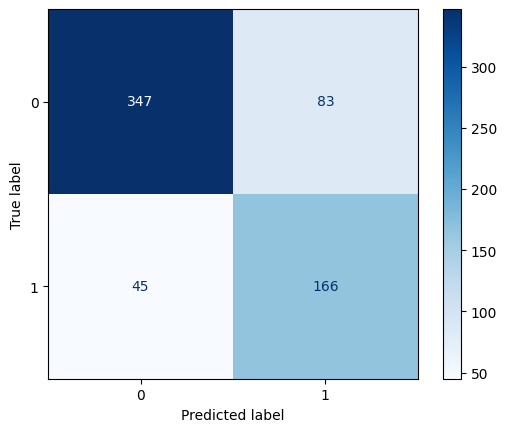

In [ ]:
test_metrics = final_trainer.evaluate(test_dataset)
print("Метрики на тестовой выборке:", test_metrics)

# Анализ
predictions = final_trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

print("\nКлассификационный отчёт:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

In [ ]:
final_trainer.save_model("very_best_model") 

### Попробуем поиграться с порогом

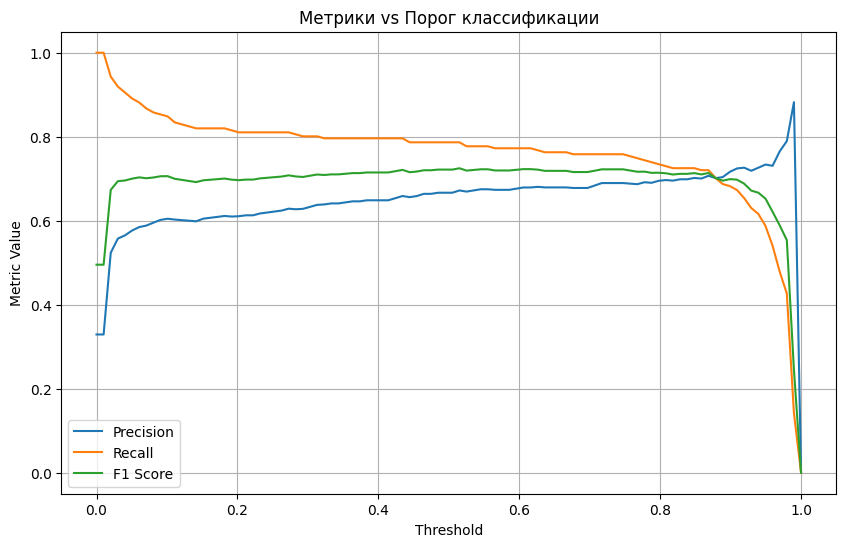

In [ ]:
# Предсказания модели на тестовом наборе
raw_preds = final_trainer.predict(test_dataset)
logits = raw_preds.predictions
labels = raw_preds.label_ids

probs = softmax(logits, axis=1)[:, 1]  # вероятность класса 1

# Вычисление метрик для разных порогов
thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], []

for thresh in thresholds:
    preds = (probs >= thresh).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

# Строим графики
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Метрики vs Порог классификации")
plt.legend()
plt.grid(True)
plt.show()


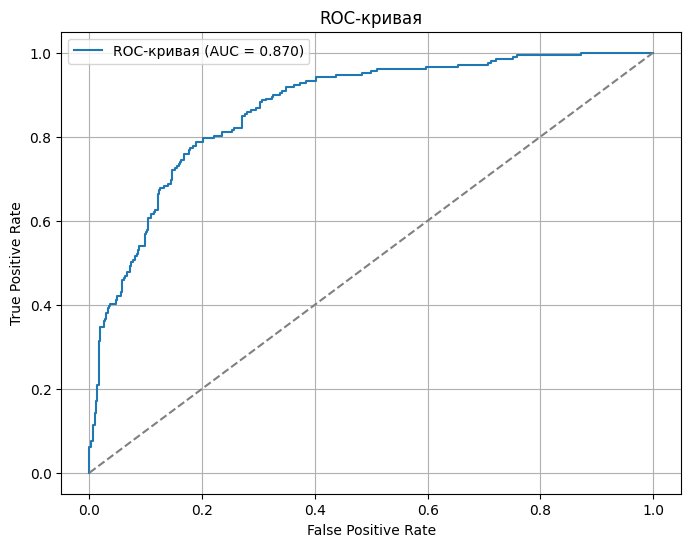

In [114]:
fpr, tpr, roc_thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-кривая (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Найдём порог с максимальным F1
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f" Оптимальный порог по F1: {best_threshold:.3f}")


Classification Report при пороге 0.515:
              precision    recall  f1-score   support

           0     0.8858    0.8116    0.8471       430
           1     0.6721    0.7867    0.7249       211

    accuracy                         0.8034       641
   macro avg     0.7789    0.7992    0.7860       641
weighted avg     0.8154    0.8034    0.8069       641



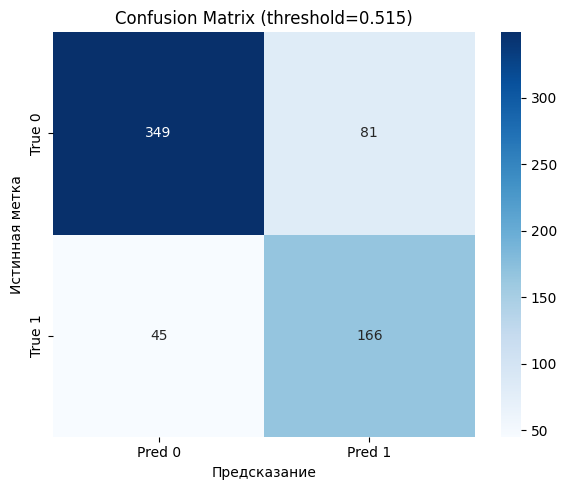

In [ ]:
# Предсказания с оптимальным порогом
final_preds = (probs >= best_threshold).astype(int)

# Classification report
print("\nClassification Report при пороге 0.515:")
print(classification_report(labels, final_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(labels, final_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel("Предсказание")
plt.ylabel("Истинная метка")
plt.title(f"Confusion Matrix (threshold={best_threshold:.3f})")
plt.tight_layout()
plt.show()

### Разметим

In [3]:
# Загрузка модели
model = XLMRobertaForSequenceClassification.from_pretrained('/root/my project ver 2/very_final_model')

# Загрузка токенизатора
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [5]:
df_for_markup=pd.read_parquet('/root/my project ver 2/df_final_lemmatized.parquet')
df_for_markup.head(3)

,Исполнитель,Трек,Собран,Жанр,Доп. информация,Фит,Совместный релиз,Альбом,Год выхода,Текст трека,Языки в тексте,Части текста,Обработанные части,Очищенные леммы
original_index,,,,,,,,,,,,,,
https://music.yandex.ru/album/17778130/track/53360237,Pavel Kempel,Русская весна,1.0,русский рэп,Нет,Нет,Несовместный релиз,Буква,2019.0,"Серые тучи, серые люди\nСерые кучи, серые будн...",[ru],"[Серые тучи, серые люди\nСерые кучи, серые буд...","[[серый, туча, ,, серый, человек, серый, куча,...","[[серый, туча, серый, человек, серый, куча, се..."
https://music.yandex.ru/album/6931563/track/50255124,The Simba,Карусель,1.0,танцевальная музыка,The Simba Remix,Нет,M'Dee,Сингл,2019.0,"Ты поздно поняла, поняла, поняла — я не такой\...",[ru],"[Ты поздно поняла, поняла, поняла — я не такой...","[[ты, поздно, понять, ,, понять, ,, понять, —,...","[[поздно, понять, понять, понять, лгать, ждать..."
https://music.yandex.ru/album/9521959/track/61168371,Кузьма,Балдёж,1.0,русский рэп,Нет,Нет,Несовместный релиз,Сингл,2019.0,"День и ночь балдеж, Россию не поймешь\nТанцуй ...","[ru, bg]","[День и ночь балдеж, Россию не поймешь\nТанцуй...","[[день, и, ночь, балдеж, ,, Россия, не, понять...","[[день, ночь, балдеж, Россия, понять, таныть, ..."


In [6]:
# Создаём Dataset
dataset_to_predict = Dataset.from_pandas(df_for_markup[["Текст трека"]], preserve_index=False)

In [9]:
def preprocess(example):
    return tokenizer(example["Текст трека"], truncation=True, padding=True)

tokenized_dataset = dataset_to_predict.map(preprocess, batched=False)

Map: 100%|██████████| 42614/42614 [01:47<00:00, 398.04 examples/s]


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator
)

/tmp/ipykernel_1182/1189794818.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Получение логитов модели
raw_predictions = trainer.predict(tokenized_dataset)
logits = raw_predictions.predictions  

# Перевод логитов в вероятности
probabilities = softmax(torch.tensor(logits), dim=1).numpy()

# Извлечение класса и его вероятности
predicted_classes = np.argmax(probabilities, axis=1)
probs_class_1 = probabilities[:, 1]

# Грузим в дф
df_for_markup["predicted_label"] = predicted_classes
df_for_markup["prob_class_1"] = probs_class_1
df_for_markup.head(3)

,Исполнитель,Трек,Собран,Жанр,Доп. информация,Фит,Совместный релиз,Альбом,Год выхода,Текст трека,Языки в тексте,Части текста,Обработанные части,Очищенные леммы,predicted_label,confidence,prob_class_1
original_index,,,,,,,,,,,,,,,,,
https://music.yandex.ru/album/17778130/track/53360237,Pavel Kempel,Русская весна,1.0,русский рэп,Нет,Нет,Несовместный релиз,Буква,2019.0,"Серые тучи, серые люди\nСерые кучи, серые будн...",[ru],"[Серые тучи, серые люди\nСерые кучи, серые буд...","[[серый, туча, ,, серый, человек, серый, куча,...","[[серый, туча, серый, человек, серый, куча, се...",0,0.988285,0.011715
https://music.yandex.ru/album/6931563/track/50255124,The Simba,Карусель,1.0,танцевальная музыка,The Simba Remix,Нет,M'Dee,Сингл,2019.0,"Ты поздно поняла, поняла, поняла — я не такой\...",[ru],"[Ты поздно поняла, поняла, поняла — я не такой...","[[ты, поздно, понять, ,, понять, ,, понять, —,...","[[поздно, понять, понять, понять, лгать, ждать...",0,0.986954,0.013046
https://music.yandex.ru/album/9521959/track/61168371,Кузьма,Балдёж,1.0,русский рэп,Нет,Нет,Несовместный релиз,Сингл,2019.0,"День и ночь балдеж, Россию не поймешь\nТанцуй ...","[ru, bg]","[День и ночь балдеж, Россию не поймешь\nТанцуй...","[[день, и, ночь, балдеж, ,, Россия, не, понять...","[[день, ночь, балдеж, Россия, понять, таныть, ...",0,0.987971,0.012029


Посмотрим что там у нас получилось

In [23]:
df_for_markup[df_for_markup['predicted_label']==0]

,Исполнитель,Трек,Собран,Жанр,Доп. информация,Фит,Совместный релиз,Альбом,Год выхода,Текст трека,Языки в тексте,Части текста,Обработанные части,Очищенные леммы,predicted_label,confidence,prob_class_1
original_index,,,,,,,,,,,,,,,,,
https://music.yandex.ru/album/17778130/track/53360237,Pavel Kempel,Русская весна,1.0,русский рэп,Нет,Нет,Несовместный релиз,Буква,2019.0,"Серые тучи, серые люди\nСерые кучи, серые будн...",[ru],"[Серые тучи, серые люди\nСерые кучи, серые буд...","[[серый, туча, ,, серый, человек, серый, куча,...","[[серый, туча, серый, человек, серый, куча, се...",0,0.988285,0.011715
https://music.yandex.ru/album/6931563/track/50255124,The Simba,Карусель,1.0,танцевальная музыка,The Simba Remix,Нет,M'Dee,Сингл,2019.0,"Ты поздно поняла, поняла, поняла — я не такой\...",[ru],"[Ты поздно поняла, поняла, поняла — я не такой...","[[ты, поздно, понять, ,, понять, ,, понять, —,...","[[поздно, понять, понять, понять, лгать, ждать...",0,0.986954,0.013046
https://music.yandex.ru/album/9521959/track/61168371,Кузьма,Балдёж,1.0,русский рэп,Нет,Нет,Несовместный релиз,Сингл,2019.0,"День и ночь балдеж, Россию не поймешь\nТанцуй ...","[ru, bg]","[День и ночь балдеж, Россию не поймешь\nТанцуй...","[[день, и, ночь, балдеж, ,, Россия, не, понять...","[[день, ночь, балдеж, Россия, понять, таныть, ...",0,0.987971,0.012029
https://music.yandex.ru/album/21509188/track/101776286,SaNni,Ламбада - Румба,1.0,русский рэп,Нет,Нет,Несовместный релиз,Сингл,2019.0,"Ламбада, румба, крути панорама\nМама хасла, пр...",[ru],"[Ламбада, румба, крути панорама\nМама хасла, п...","[[ламбада, ,, румба, ,, крутить, панорама, мам...","[[ламбада, румба, крутить, панорама, мама, хас...",0,0.885082,0.114918
https://music.yandex.ru/album/30947715/track/125364879,SaNni,Мой магнит,1.0,русский рэп,Нет,Нет,Несовместный релиз,Сингл,2024.0,"Облака мне напомнят густой дым, я хочу вдыхать...",[ru],"[Облака мне напомнят густой дым, я хочу вдыхат...","[[облако, я, напомнить, густой, дым, ,, я, хот...","[[облако, напомнить, густой, дым, хотеть, вдых...",0,0.985334,0.014666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://music.yandex.ru/album/28241508/track/117972354,Meep,Десятилетие,1.0,русский рэп,Нет,Нет,VELIAL SQUAD,CREEPSHOW,2023.0,"Я, а\n\nДа, я русский, скажи, есть ли со мной ...",[ru],"[Я, а, Да, я русский, скажи, есть ли со мной Б...","[[я, ,, а], [да, ,, я, русский, ,, сказать, ,,...","[[], [русский, сказать, Бог, сказать, стать, н...",0,0.973675,0.026325
https://music.yandex.ru/album/22776021/track/105293921,SAPA13,Svet,1.0,русский рэп,Нет,Нет,Ralfkon,Kendama Bae,2022.0,"Я, я не синоптик, но\nЯ точно знаю погоду в до...",[ru],"[Я, я не синоптик, но\nЯ точно знаю погоду в д...","[[я, ,, я, не, синоптика, ,, но, я, точно, зна...","[[синоптика, точно, знать, погода, дом, дом, -...",0,0.986913,0.013087
https://music.yandex.ru/album/9414961/track/60721279,Say Mo,Я — Ра,1.0,русский рэп,Нет,Нет,Несовместный релиз,Я пот бит,2019.0,"Я, я, эй-эй\nЯ, я, эй\nЯ, я, я\n\nБудьте готов...","[ru, de, uk]","[Я, я, эй-эй\nЯ, я, эй\nЯ, я, я, Будьте готовы...","[[я, ,, я, ,, эй-эй, я, ,, я, ,, эй, я, ,, я, ...","[[эй-эй, эй], [готовый, связь, Номад, готовый,...",0,0.987173,0.012827


In [24]:
df_for_markup.to_parquet('full_size_markuped_df_hq.parquet')